Data loaded successfully
Total rows count: 200000

===== Timestamp Debugging =====
First timestamp: 2025-03-14 10:08:07.171000
Last timestamp: 2025-03-14 10:08:50.215000
Unique timestamps count: 7013
Total rows count after cleanup: 200000

===== Performance Metrics =====
Total Successful Requests: 200000
Mean Latency: 261.65 ms
Median Latency: 248.00 ms
99th Percentile Latency: 781.00 ms
Min Latency: 10.00 ms
Max Latency: 1207.00 ms
Wall Time: 43.08 seconds

--- Throughput (Naive) ---
Throughput (naive) = Total Requests / Wall Time = 4642.20 req/s

--- Throughput (Little's Law) ---
Average Concurrency (L) = 1214.64
Average Latency (W) = 0.2617 seconds
Throughput (λ = L/W) = 4642.20 req/s


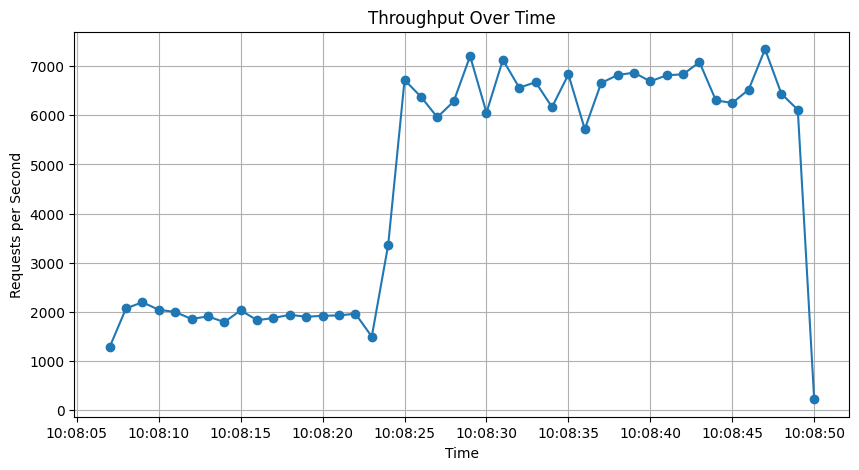

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

try:
    # Load CSV with explicit data types, skipping the first row if needed
    df = pd.read_csv("/Users/xinruiwu/Desktop/cs6500/cs6650-skier/Assignment2/Client/output3.csv",
                     names=["start_time", "request_type", "latency", "response_code"],
                     header=0,  # Use header=0 if the first row contains column names
                     dtype={"start_time": "str", "request_type": "str", "response_code": "str"},
                     low_memory=False)

    print("Data loaded successfully")
    print(f"Total rows count: {len(df)}")

    # Convert latency
    df["latency"] = pd.to_numeric(df["latency"], errors="coerce")

    # Convert start_time
    df["start_time"] = pd.to_numeric(df["start_time"], errors="coerce")
    df["start_time"] = pd.to_datetime(df["start_time"], unit="ms", errors="coerce")

    # Drop rows where start_time or latency is invalid values
    df = df.dropna(subset=["start_time", "latency"])

    # Debug timestamp information
    print("\n===== Timestamp Debugging =====")
    print(f"First timestamp: {df['start_time'].min()}")
    print(f"Last timestamp: {df['start_time'].max()}")
    print(f"Unique timestamps count: {df['start_time'].nunique()}")
    print(f"Total rows count after cleanup: {len(df)}")

    # Handle duplicate timestamps by adding a small delta in milliseconds
    df["start_time"] = df["start_time"] + pd.to_timedelta(df.groupby("start_time").cumcount(), unit="ms")

    # Set datetime index
    df.set_index("start_time", inplace=True)

    # Compute latency metrics
    mean_latency = df["latency"].mean()
    median_latency = df["latency"].median()
    p99_latency = df["latency"].quantile(0.99)
    min_latency = df["latency"].min()
    max_latency = df["latency"].max()

    # Compute throughput over time (requests per second, resampled by 1S)
    throughput_series = df.resample("1S")["latency"].count()

    # Compute overall throughput (naive way: total requests / total test duration)
    if not df.empty and df.index.notna().all():
        wall_time = (df.index.max() - df.index.min()).total_seconds()
        throughput_naive = len(df) / wall_time if wall_time > 0 else 0
    else:
        wall_time = 0
        throughput_naive = 0

    # ============== LITTLE'S LAW CALCULATION ==============
    #
    # Little's Law: L = λ * W
    #   L = average number of requests in the system (average concurrency)
    #   λ = throughput (requests/second)
    #   W = average waiting (latency) in *seconds*
    #
    #   L = (1 / total_time_in_seconds) * sum_of_all_latencies_in_seconds
    #
    # Then solve for λ:
    #   λ = L / W

    # Total test duration in seconds
    total_test_time_s = wall_time  # same as 'wall_time' above

    # Convert sum of latencies to seconds
    sum_latencies_s = df["latency"].sum() / 1000.0

    # Average concurrency (L) over the entire test
    # (sum of "time in system" for each request) / total test time
    if total_test_time_s > 0:
        average_concurrency = sum_latencies_s / total_test_time_s
    else:
        average_concurrency = 0

    # Average latency in seconds
    average_latency_s = mean_latency / 1000.0

    # Throughput via Little's Law: λ = L / W
    if average_latency_s > 0:
        throughput_little = average_concurrency / average_latency_s
    else:
        throughput_little = 0

    print("\n===== Performance Metrics =====")
    print(f"Total Successful Requests: {len(df)}")
    print(f"Mean Latency: {mean_latency:.2f} ms")
    print(f"Median Latency: {median_latency:.2f} ms")
    print(f"99th Percentile Latency: {p99_latency:.2f} ms")
    print(f"Min Latency: {min_latency:.2f} ms")
    print(f"Max Latency: {max_latency:.2f} ms")
    print(f"Wall Time: {wall_time:.2f} seconds")

    # Print both throughput calculations
    print(f"\n--- Throughput (Naive) ---")
    print(f"Throughput (naive) = Total Requests / Wall Time = {throughput_naive:.2f} req/s")

    print(f"\n--- Throughput (Little's Law) ---")
    print(f"Average Concurrency (L) = {average_concurrency:.2f}")
    print(f"Average Latency (W) = {average_latency_s:.4f} seconds")
    print(f"Throughput (λ = L/W) = {throughput_little:.2f} req/s")

    # === PLOTTING CODE ===
    plt.figure(figsize=(10, 5))
    plt.plot(throughput_series.index, throughput_series.values, marker='o', linestyle='-')
    plt.xlabel("Time")
    plt.ylabel("Requests per Second")
    plt.title("Throughput Over Time")
    plt.grid(True)
    plt.savefig("Throughput_Over_Time1.png", dpi=300)
    plt.show()

except Exception as e:
    print(f"Error: {e}")
